Se escogen dos clasificadores para un problema `Multi-class`:
- Logistic Regression
- Random Forest

El dataset de clasificación será:
- Bank Marketing dataset

## Importing Libraries

In [82]:
import pandas as pd
import numpy as np
from ucimlrepo import fetch_ucirepo
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from scipy.stats import t
from statsmodels.stats.contingency_tables import mcnemar
from sklearn.metrics import confusion_matrix

## Loading Dataset

In [83]:
bank_marketing = fetch_ucirepo(id=222)
X_bank_marketing = bank_marketing.data.features
y_bank_marketing = bank_marketing.data.targets['y']
bank_marketing_df = pd.concat([X_bank_marketing, y_bank_marketing], axis=1)
bank_marketing_df = bank_marketing_df.dropna(subset=['job', 'education'])
bank_marketing_df = bank_marketing_df.drop(columns=['contact', 'poutcome'])

Let's visualize the class proportions in the `Bank Marketing`

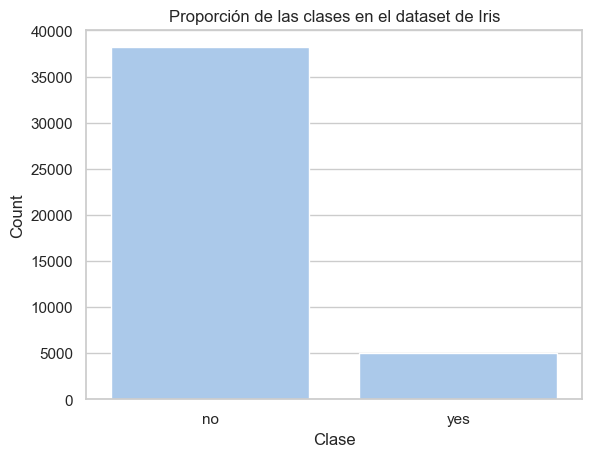

In [84]:
sns.set(style="whitegrid", palette="pastel")
sns.countplot(x='y', data=bank_marketing_df)
plt.xlabel("Clase")
plt.ylabel("Count")
plt.title("Proporción de las clases en el dataset de Iris")
plt.show()

The dataset is unbalanced, in order to make it simple, we perform an undersampling

In [85]:
df_majority = bank_marketing_df[bank_marketing_df.y == 'no']
df_minority = bank_marketing_df[bank_marketing_df.y == 'yes']

df_majority_undersampled = df_majority.sample(len(df_minority), random_state=42)

bank_marketing_df = pd.concat([df_majority_undersampled, df_minority])

bank_marketing_df = bank_marketing_df.sample(frac=1, random_state=42).reset_index(drop=True)

X_bank_marketing = bank_marketing_df.drop(columns=['y'])
y_bank_marketing = bank_marketing_df['y']

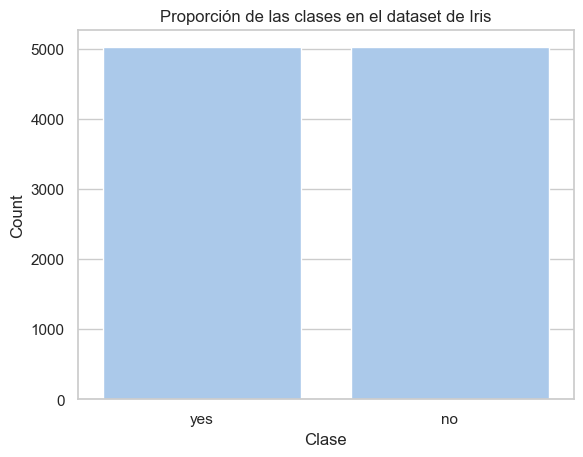

In [86]:
sns.set(style="whitegrid", palette="pastel")
sns.countplot(x='y', data=bank_marketing_df)
plt.xlabel("Clase")
plt.ylabel("Count")
plt.title("Proporción de las clases en el dataset de Iris")
plt.show()

Initialize data transformation pipelines (One Hot encoding for Catagorial data and Standard Scaling for numerical)

In [87]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

num_features = X_bank_marketing.select_dtypes(include=['int64', 'float64']).columns
cat_features = X_bank_marketing.select_dtypes(include=['object']).columns

num_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])
cat_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
    ])

logreg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

## Test `t-Student` with `5x2-Cross Validation`

### `5x2 Cross Validation`

#### Performance Metric Selection

In order to evaluate the models and determine the statistical significant difference between the models’ performance, AUC is the chosen metric. This decision is based on the fact that this metric is ideal for measuring overall class separation capability, especially in unbalanced problems. Other option would be F1-Score, due to its capacity to measure performance by taking into account Recall and Precision. Recall prioritizes the minimization of False Negatives, while Precision prioritizes the minimization of False Positives.

In [88]:
from sklearn.model_selection import StratifiedKFold
strat_f_fold = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

In [89]:
performance_logreg = []
performance_rf = []

for repetition in range(5):
    print(f"\nRepetition {repetition}")
    for i, (train_index, test_index) in enumerate(strat_f_fold.split(X_bank_marketing, y_bank_marketing)):
        print(f"Fold {i}")
        X_train, X_test = X_bank_marketing.iloc[train_index], X_bank_marketing.iloc[test_index]
        y_train, y_test = y_bank_marketing.iloc[train_index], y_bank_marketing.iloc[test_index]

        # Training and evaluate each models
        logreg.fit(X_train, y_train)
        rf.fit(X_train, y_train)
        y_pred_logreg = logreg.predict_proba(X_test)
        y_pred_rf = rf.predict_proba(X_test)
        roc_auc_score_logreg = roc_auc_score(
            y_test, 
            y_pred_logreg[:,1], # Probabilities of positive class, `yes` is in position 1
            labels=logreg.classes_
        )
        roc_auc_score_rf = roc_auc_score(
            y_test, 
            y_pred_rf[:,1], 
            labels=logreg.classes_
        )
        print(f"AUC Logistic Regression: {roc_auc_score_logreg}")
        print(f"AUC Random Forest: {roc_auc_score_rf}")
        performance_logreg.append(roc_auc_score_logreg)
        performance_rf.append(roc_auc_score_rf)

differences = np.array(performance_logreg) - np.array(performance_rf)
t_statistic = differences.mean() / differences.std(ddof=1)/np.sqrt(len(differences))

alpha = 0.05
t_critical = t.ppf(1-alpha/2, len(differences)-1)

if t_statistic > t_critical:
    print("\nReject the null hypothesis. Models have statistical significant different performance.")
else:
    print("\nAccept the null hypothesis. Models have no statistical significant different performance.")


Repetition 0
Fold 0
AUC Logistic Regression: 0.8993532837982996
AUC Random Forest: 0.9197177042526826
Fold 1
AUC Logistic Regression: 0.8917840386760406
AUC Random Forest: 0.9094410886918276

Repetition 1
Fold 0
AUC Logistic Regression: 0.8993532837982996
AUC Random Forest: 0.9191831638003937
Fold 1
AUC Logistic Regression: 0.8917840386760406
AUC Random Forest: 0.9100646398872848

Repetition 2
Fold 0
AUC Logistic Regression: 0.8993532837982996
AUC Random Forest: 0.9182571188761481
Fold 1
AUC Logistic Regression: 0.8917840386760406
AUC Random Forest: 0.9112969071543378

Repetition 3
Fold 0
AUC Logistic Regression: 0.8993532837982996
AUC Random Forest: 0.9197996544288796
Fold 1
AUC Logistic Regression: 0.8917840386760406
AUC Random Forest: 0.9098019709295038

Repetition 4
Fold 0
AUC Logistic Regression: 0.8993532837982996
AUC Random Forest: 0.9182553735674587
Fold 1
AUC Logistic Regression: 0.8917840386760406
AUC Random Forest: 0.9113141222445938

Accept the null hypothesis. Models have

## Test de `McNemar`

In [93]:
from sklearn.model_selection import train_test_split

X_bm_train, X_bm_test, y_bm_train, y_bm_test = train_test_split(X_bank_marketing, y_bank_marketing, test_size=0.30, random_state=42, stratify=y_bank_marketing)
logreg.fit(X_bm_train, y_bm_train)
rf.fit(X_bm_train, y_bm_train)

y_pred_logreg = logreg.predict(X_bm_test)
y_pred_rf = rf.predict(X_bm_test)

ct_table =  confusion_matrix(y_pred_logreg == y_bm_test, y_pred_rf == y_bm_test)

result = mcnemar(ct_table, exact=False) # exact=False n_{10} + n_{01} > 25, approximate Chi2
print(result)
alpha = 0.05
if result.pvalue > alpha:
    print("\nAccept the null hypothesis. Models have no statistical significant different performance.")
else:
    print("\nReject the null hypothesis. Models have statistical significant difference")

pvalue      1.6484631009361956e-17
statistic   72.52599388379205

Reject the null hypothesis. Models have statistical significant difference


In order to select the difinitive model, we can choose the model based on the analysis of discordant errors and AUC performance metric

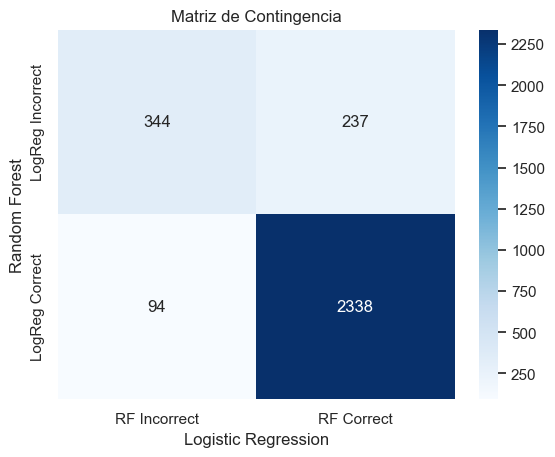

In [91]:
sns.heatmap(ct_table, annot=True, fmt='d', cmap='Blues', xticklabels=['RF Incorrect', 'RF Correct'], yticklabels=['LogReg Incorrect', 'LogReg Correct'])
plt.ylabel('Random Forest')
plt.xlabel('Logistic Regression')
plt.title('Matriz de Contingencia')
plt.show()

Random Forest hits more instances in the case where Logistic regression fails than in the opposite case

In [92]:
y_pred_logreg = logreg.predict_proba(X_bm_test)
y_pred_rf = rf.predict_proba(X_bm_test)
roc_auc_score_logreg = roc_auc_score(
    y_bm_test, 
    y_pred_logreg[:,1], # Probabilities of positive class, `yes` is in position 1
    labels=logreg.classes_
)
roc_auc_score_rf = roc_auc_score(
    y_bm_test, 
    y_pred_rf[:,1], 
    labels=logreg.classes_
)
print(f"AUC Logistic Regression: {roc_auc_score_logreg}")
print(f"AUC Random Forest: {roc_auc_score_rf}")
if roc_auc_score_logreg > roc_auc_score_rf:
    print("Logistic Regression has better performance")
else:
    print("Random Forest has better performance")

AUC Logistic Regression: 0.9014611758672013
AUC Random Forest: 0.9232878263543922
Random Forest has better performance


AUC metric is slightly higer in Random Forest